# SphereFace in Keras

This notebook converts the pytorch weights of SphereFace model into Keras.

Ref repo: https://github.com/clcarwin/sphereface_pytorch

In [74]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.python.keras.engine import training
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Convolution2D, Add, Activation, PReLU, Dense, Input
import torch
from deepface.commons import functions
from deepface.commons import distance as dst
from tqdm import tqdm
import matplotlib.pyplot as plt

In [75]:
print("tf version: ",tensorflow.__version__)
print("torch version: ",torch.__version__)

tf version:  1.9.0
torch version:  1.5.0+cpu


## Torch model

In [76]:
#Network structure: https://github.com/clcarwin/sphereface_pytorch/blob/master/net_sphere.py
#Pre-trained weights: https://github.com/clcarwin/sphereface_pytorch/blob/master/model/sphere20a_20171020.7z
PATH = "sphere20a_20171020.pth"

model = torch.load(PATH)
print(type(model))

model_layers = list(model.items())

<class 'collections.OrderedDict'>


In [77]:
source_layers = []

source = {}
idx = 0
for layer in model_layers:
    layer_name = layer[0]
    layer_weights = layer[1].detach().numpy()
    if idx < len(model_layers) - 1:
        layer_weights = np.transpose(layer_weights)
    
    if 'relu' in layer_name: # and len(layer_weights.shape) == 3 and layer_weights[0] == 1 and layer_weights[1] == 1: 
        layer_weights = np.expand_dims(layer_weights, axis = 0)
        layer_weights = np.expand_dims(layer_weights, axis = 0)
    
    print("storing weights of ",layer_name, layer_weights.shape)
    source[layer_name] = layer_weights
    source_layers.append(layer_name) #to revalidate the keras model later
    #np.save("source_weights/%s" % (layer_name), layer_weights)
    idx = idx + 1

storing weights of  conv1_1.weight (3, 3, 3, 64)
storing weights of  conv1_1.bias (64,)
storing weights of  relu1_1.weight (1, 1, 64)
storing weights of  conv1_2.weight (3, 3, 64, 64)
storing weights of  conv1_2.bias (64,)
storing weights of  relu1_2.weight (1, 1, 64)
storing weights of  conv1_3.weight (3, 3, 64, 64)
storing weights of  conv1_3.bias (64,)
storing weights of  relu1_3.weight (1, 1, 64)
storing weights of  conv2_1.weight (3, 3, 64, 128)
storing weights of  conv2_1.bias (128,)
storing weights of  relu2_1.weight (1, 1, 128)
storing weights of  conv2_2.weight (3, 3, 128, 128)
storing weights of  conv2_2.bias (128,)
storing weights of  relu2_2.weight (1, 1, 128)
storing weights of  conv2_3.weight (3, 3, 128, 128)
storing weights of  conv2_3.bias (128,)
storing weights of  relu2_3.weight (1, 1, 128)
storing weights of  conv2_4.weight (3, 3, 128, 128)
storing weights of  conv2_4.bias (128,)
storing weights of  relu2_4.weight (1, 1, 128)
storing weights of  conv2_5.weight (3, 3,

## Build SphereFace in Keras

In [78]:
#Building SphereFace in Keras is heavily inspired the repo: https://github.com/radonys/SphereFace-Keras/blob/master/sphereface_20.py
    
shared_axes = [1, 2]

img_input = Input(shape=(96, 112, 3)) #torch shape: (1,3,112,96)

#Conv 1.X

conv1_1 = Convolution2D(64, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv1_1')(img_input)
relu1_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu1_1')(conv1_1)
    
conv1_2 = Convolution2D(64, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv1_2')(relu1_1)
relu1_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu1_2')(conv1_2)

conv1_3 = Convolution2D(64, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv1_3')(relu1_2)
relu1_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu1_3')(conv1_3)

res1_3 = Add()([relu1_1, relu1_3])

#Conv 2.X

conv2_1 = Convolution2D(128, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv2_1')(res1_3)
relu2_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_1')(conv2_1)

conv2_2 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_2')(relu2_1)
relu2_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_2')(conv2_2)

conv2_3 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_3')(relu2_2)
relu2_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_3')(conv2_3)

res2_3 = Add()([relu2_1, relu2_3])

conv2_4 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_4')(res2_3)
relu2_4 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_4')(conv2_4)

conv2_5 = Convolution2D(128, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv2_5')(relu2_4)
relu2_5 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu2_5')(conv2_5)

res2_5 = Add()([res2_3, relu2_5])

#Conv 3.X

conv3_1 = Convolution2D(256, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv3_1')(res2_5)
relu3_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_1')(conv3_1)

conv3_2 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_2')(relu3_1)
relu3_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_2')(conv3_2)

conv3_3 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_3')(relu3_2)
relu3_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_3')(conv3_3)

res3_3 = Add()([relu3_1, relu3_3])

conv3_4 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_4')(res3_3)
relu3_4 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_4')(conv3_4)

conv3_5 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_5')(relu3_4)
relu3_5 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_5')(conv3_5)

res3_5 = Add()([res3_3, relu3_5])

conv3_6 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_6')(res3_5)
relu3_6 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_6')(conv3_6)

conv3_7 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_7')(relu3_6)
relu3_7 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_7')(conv3_7)

res3_7 = Add()([res3_5, relu3_7])

conv3_8 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_8')(res3_7)
relu3_8 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_8')(conv3_8)

conv3_9 = Convolution2D(256, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv3_9')(relu3_8)
relu3_9 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu3_9')(conv3_9)

res3_9 = Add()([res3_7, relu3_9])

#Conv 4.X

conv4_1 = Convolution2D(512, 3, strides=2, padding='same', use_bias=True, bias_initializer='zeros', name = 'conv4_1')(res3_9)
relu4_1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu4_1')(conv4_1)

conv4_2 = Convolution2D(512, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv4_2')(relu4_1)
relu4_2 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu4_2')(conv4_2)

conv4_3 = Convolution2D(512, 3, strides=1, padding='same', bias_initializer='zeros', name = 'conv4_3')(relu4_2)
relu4_3 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axes, name = 'relu4_3')(conv4_3)

res4_3 = Add()([relu4_1, relu4_3])

flatten = tensorflow.keras.layers.Flatten()(res4_3)
fc5 = Dense(512, use_bias=True, bias_initializer='zeros', name = 'fc5')(flatten)

fc6 = Dense(10574, activation=None, use_bias=False, name='fc6')(fc5)

#model = tensorflow.keras.models.Model(img_input, fc6) #classification
model = tensorflow.keras.models.Model(img_input, fc5) #embedding

In [79]:
if True:
    for layer in model.layers[1:]:
        if len(layer.get_weights()) > 0:
            print(layer.name, ": ", len(layer.get_weights()), layer.output_shape)

conv1_1 :  2 (None, 48, 56, 64)
relu1_1 :  1 (None, 48, 56, 64)
conv1_2 :  2 (None, 48, 56, 64)
relu1_2 :  1 (None, 48, 56, 64)
conv1_3 :  2 (None, 48, 56, 64)
relu1_3 :  1 (None, 48, 56, 64)
conv2_1 :  2 (None, 24, 28, 128)
relu2_1 :  1 (None, 24, 28, 128)
conv2_2 :  2 (None, 24, 28, 128)
relu2_2 :  1 (None, 24, 28, 128)
conv2_3 :  2 (None, 24, 28, 128)
relu2_3 :  1 (None, 24, 28, 128)
conv2_4 :  2 (None, 24, 28, 128)
relu2_4 :  1 (None, 24, 28, 128)
conv2_5 :  2 (None, 24, 28, 128)
relu2_5 :  1 (None, 24, 28, 128)
conv3_1 :  2 (None, 12, 14, 256)
relu3_1 :  1 (None, 12, 14, 256)
conv3_2 :  2 (None, 12, 14, 256)
relu3_2 :  1 (None, 12, 14, 256)
conv3_3 :  2 (None, 12, 14, 256)
relu3_3 :  1 (None, 12, 14, 256)
conv3_4 :  2 (None, 12, 14, 256)
relu3_4 :  1 (None, 12, 14, 256)
conv3_5 :  2 (None, 12, 14, 256)
relu3_5 :  1 (None, 12, 14, 256)
conv3_6 :  2 (None, 12, 14, 256)
relu3_6 :  1 (None, 12, 14, 256)
conv3_7 :  2 (None, 12, 14, 256)
relu3_7 :  1 (None, 12, 14, 256)
conv3_8 :  2 (No

In [80]:
#model.summary()

## Transfer weights

In [81]:
target_layers = []
for layer in model.layers:
    
    if len(layer.get_weights()) > 0:
        layer_name = layer.name
        
        weights = []
        w_idx = 0
        for weight in layer.weights:
            task = 'weight' if w_idx == 0 else 'bias'
            
            source_weight = np.load("source_weights/%s.%s.npy" % (layer_name, task))
            source_shape = source_weight.shape
            target_shape = weight.shape

            #print(layer_name, task, source_shape, target_shape, source_shape == target_shape)
            if source_shape != target_shape:
                raise ValueError(layer_name, task, " has incompatible weights. source: ", source_shape,", current: ", target_shape)
            
            weights.append(source_weight)
            w_idx = w_idx + 1
            
            target_layers.append("%s.%s" % (layer.name, task))
        
        model.get_layer(layer_name).set_weights(weights)
        layer.set_weights(weights)
        print(layer.name," is updated")

conv1_1  is updated
relu1_1  is updated
conv1_2  is updated
relu1_2  is updated
conv1_3  is updated
relu1_3  is updated
conv2_1  is updated
relu2_1  is updated
conv2_2  is updated
relu2_2  is updated
conv2_3  is updated
relu2_3  is updated
conv2_4  is updated
relu2_4  is updated
conv2_5  is updated
relu2_5  is updated
conv3_1  is updated
relu3_1  is updated
conv3_2  is updated
relu3_2  is updated
conv3_3  is updated
relu3_3  is updated
conv3_4  is updated
relu3_4  is updated
conv3_5  is updated
relu3_5  is updated
conv3_6  is updated
relu3_6  is updated
conv3_7  is updated
relu3_7  is updated
conv3_8  is updated
relu3_8  is updated
conv3_9  is updated
relu3_9  is updated
conv4_1  is updated
relu4_1  is updated
conv4_2  is updated
relu4_2  is updated
conv4_3  is updated
relu4_3  is updated
fc5  is updated


## Revalidate the Keras model

There are 454590 images of 10574 identites in CASIA database and SphereFace was trained on this data set.

FC6 layer has 10574 outputs to classify identities. It is expected that fc6 does not appear in the representation model

In [82]:
set(target_layers) - set(source_layers)

set()

In [83]:
set(source_layers) - set(target_layers)

{'fc6.weight'}

## Save pre-trained model

In [84]:
model.save_weights("sphereface_weights.h5")

## Load weights directly

In [85]:
#model.load_weights("sphereface_weights.h5")

## Prediction

In [86]:
w, h = model.layers[0].input_shape[1:3]
print("input shape is ", w, h)

input shape is  96 112


In [134]:
def verify(img1_path, img2_path, show = False):
    
    backend = 'opencv'

    img1 = functions.preprocess_face(img1_path, target_size = (h, w), detector_backend = backend) #(1, 112, 96, 3)
    img2 = functions.preprocess_face(img2_path, target_size = (h, w), detector_backend = backend) #(1, 112, 96, 3)
    
    #-----------------------------------------------------
    
    if show:
        fig = plt.figure()
        
        ax1 = fig.add_subplot(1,2,1)
        plt.imshow(img1[0][:,:,::-1])
        #plt.axis('off')
        
        ax1 = fig.add_subplot(1,2,2)
        plt.imshow(img2[0][:,:,::-1])
        #plt.axis('off')
        
        plt.show()
    
    img1_embedding = model.predict(img1)[0]
    img2_embedding = model.predict(img2)[0]
    
    euclidean = dst.findEuclideanDistance(img1_embedding, img2_embedding)
    euclidean_l2 = dst.findEuclideanDistance(dst.l2_normalize(img1_embedding), dst.l2_normalize(img2_embedding))
    cosine = dst.findCosineDistance(img1_embedding, img2_embedding)
    
    #-----------------------------------------------------
    
    return (euclidean, euclidean_l2, cosine)

## True positives

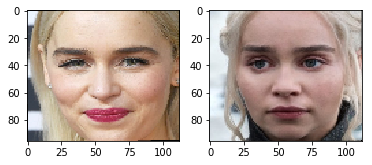

(0.712342, 0.77815807, 0.30276501178741455)

In [135]:
verify("dataset/1.jpg", "dataset/10.jpg", show = True)

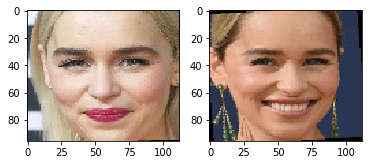

(0.768558, 0.84708613, 0.35877740383148193)

In [136]:
verify("dataset/1.jpg", "dataset/2.jpg", show = True)

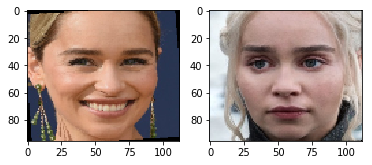

(0.68401587, 0.7610985, 0.28963547945022583)

In [137]:
verify("dataset/2.jpg", "dataset/10.jpg", show = True)

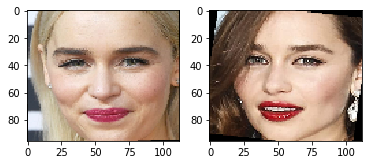

(0.70004684, 0.7793518, 0.30369454622268677)

In [138]:
verify("dataset/1.jpg", "dataset/3.jpg", show = True)

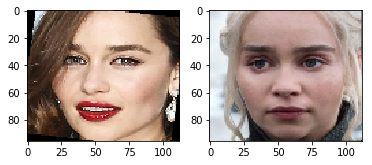

(0.75021595, 0.8441183, 0.35626786947250366)

In [139]:
verify("dataset/3.jpg", "dataset/10.jpg", show = True)

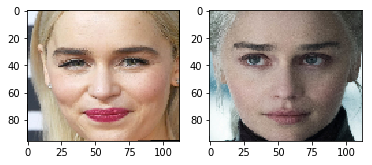

(0.6955904, 0.7314913, 0.267539918422699)

In [140]:
verify("dataset/1.jpg", "dataset/4.jpg", show = True)

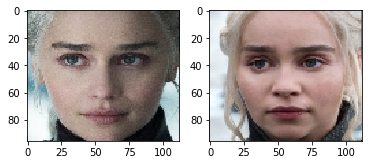

(0.67765546, 0.7173664, 0.2573072910308838)

In [141]:
verify("dataset/4.jpg", "dataset/10.jpg", show = True)

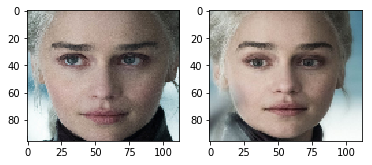

(0.7996368, 0.843876, 0.3560634255409241)

In [142]:
verify("dataset/4.jpg", "dataset/5.jpg", show = True)

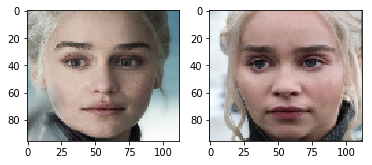

(0.79600585, 0.87267363, 0.38077956438064575)

In [143]:
verify("dataset/5.jpg", "dataset/10.jpg", show = True)

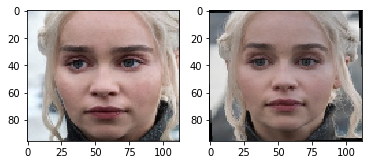

(0.5746973, 0.6707309, 0.2249400019645691)

In [144]:
verify("dataset/10.jpg", "dataset/11.jpg", show = True)

## False positive

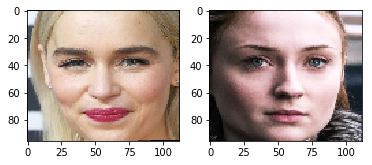

(0.8402974, 0.89021474, 0.3962411880493164)

In [145]:
verify("dataset/1.jpg", "dataset/6.jpg", show = True)

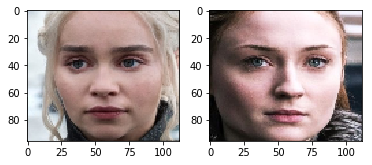

(0.80154616, 0.85559434, 0.3660208582878113)

In [146]:
verify("dataset/10.jpg", "dataset/6.jpg", show = True)

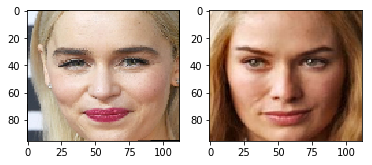

(0.80377513, 0.8046105, 0.3236989974975586)

In [147]:
verify("dataset/1.jpg", "dataset/7.jpg", show = True)

## Test SphereFace on unit test items of deepface

https://github.com/serengil/deepface/tree/master/tests/dataset

In [ ]:
df = pd.read_csv("../deepface/tests/dataset/master.csv")

In [ ]:
df.head()

In [ ]:
distances = []
#for index, instance in df.iterrows():
for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    
    distance = []
    decision = instance["Decision"]
    img1_path = "../deepface/tests/dataset/"+instance["file_x"]
    img2_path = "../deepface/tests/dataset/"+instance["file_y"]
    
    try:
        euclidean, euclidean_l2, cosine = verify(img1_path, img2_path)
        
        distance.append(img1_path)
        distance.append(img2_path)
        distance.append(decision)
        distance.append(cosine)
        distance.append(euclidean)
        distance.append(euclidean_l2)
        distances.append(distance)
    except Exception as err:
        print("", end = '')
    
    if index == 80:
        break

In [ ]:
pivot = pd.DataFrame(distances, columns = ["img1_path", "img2_path", "Decision", "cosine", "euclidean", "euclidean_l2"])

In [ ]:
pivot.head()

In [ ]:
pivot.Decision.value_counts()

In [ ]:
#pivot.to_csv('sphereface_scores.csv', index=False)

## Visualize distributions

In [ ]:
metrics = ['euclidean', 'euclidean_l2', 'cosine']

In [ ]:
fig = plt.figure(figsize=(15, 3))

figure_idx = 1
for metric in metrics:
    ax1 = fig.add_subplot(1, 3, figure_idx)
    pivot[pivot['Decision'] == 'Yes'][metric].plot(kind='kde', title = metric, label = 'Yes', legend = True)
    pivot[pivot['Decision'] == 'No'][metric].plot(kind='kde', title = metric, label = 'Yes', legend = True)
    figure_idx = figure_idx + 1
plt.show()

## Find best split points

In [ ]:
from chefboost import Chefboost as chef

In [ ]:
config = {'algorithm': 'C4.5'}

In [ ]:
tree1 = chef.fit(pivot[['euclidean', 'Decision']].copy())

In [ ]:
tree2 = chef.fit(pivot[['euclidean_l2', 'Decision']].copy())

In [ ]:
tree3 = chef.fit(pivot[['cosine', 'Decision']].copy())

In [ ]:
metric = 'euclidean'

if metric == 'euclidean': #Accuracy:  87.31884057971014 %, Precision:  52.381 %, Recall:  59.4595 %, F1:  55.6962 %
    threshold = 0.5972635061702709
elif metric == 'euclidean_l2': #Accuracy:  87.31884057971014 %, Precision:  52.2727 %, Recall:  62.1622 %, F1:  56.7901 %
    threshold = 0.7399999427950562
elif metric == 'cosine': #Accuracy:  87.31884057971014 %, Precision:  52.2727 %, Recall:  62.1622 %, F1:  56.7901 %
    threshold = 0.27392937070928874